In [5]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation

# Set up simulation params. 
"""Time step size and total time is primary source of runtime for rendering animation"""
dt = 1e-9 # time step size, seconds
t0 = 0.0
tf = 6e-3 # total time evolution, seconds
t_eval = np.arange(t0, tf, dt)


# Wire properties
""" 
Wire property source:
https://www.tribology-abc.com/calculators/properties_of_common_spring_materials.pdf <-- ASTM A228
https://optimumspring.com/technical_resources/materials/carbon_steels/music_wire_228_spring_wire.aspx <-- For mass density 
"""
l = 2 # length of wire, meters
dz = 100e-6 # wire step size, meters
rho = 7850 # mass density, kg/m^3
tensile_str = 2751e6 # Tensile Strength of wire, Pa
young_mod = 207e9 # elastic modulus of wire, Pa
dia = 4e-3 # diameter of wire, meters
cs_area = np.pi * dia**2 / 4 # cross sectional area of wire, m^2
mu = rho * cs_area # linear mass density, kg/m
tension = 0.1 * tensile_str * cs_area # Tension on wire, N
v_press = np.sqrt(young_mod / rho) # wavespeed for longitudinal wave, m/s
v_shear = np.sqrt(tension / mu) # wavespeed for transverse waves, m/s

#Particle Properties
relativistic = [3e8, 1.782e-24] # c [m/s], 1 TeV/c^2 [kg]
thermal_neut = [1919.62, 1.674e-27] # [m/s], [kg] --> T = 298 K, mv^2 = (3/2) k_b T
gal_orbit = [220e3, 1.782e-24] # [m/s], 1 TeV/c^2 [kg]
parts = [relativistic, thermal_neut, gal_orbit]
titles = ["Custom", "Relativistic DM", "Thermal Neutron", "Galactic Orbit DM"]
G = 6.67430e-11 # gravitational constant
M = np.array([p[1] for p in parts]) # mass of inciting particle, meters/second
v_p = np.array([p[0] for p in parts]) # velocity of inciting particle, meters / second

#Impact Properties
z0 = l / 4 # position of particle track and wire 'intersection', meters
bs = np.array([0.01, .05, 0.1]) # shortest distance between wire and particle track, meters
theta = 45 * (np.pi / 180) # Angle between particle track and z (wire) axes, radians
phi = 90 * (np.pi / 180) # Angle between particle track and x axes, radians

zwire = np.arange(0 - z0, l - z0, dz) # define wire along z axes s.t. z0 is at z_string == 0
costheta = np.cos(theta)
sintheta = np.sin(theta)
cosphi = np.cos(phi)
sinphi = np.sin(phi)
small = G * (M / v_p)

In [6]:
def theory_abs (t_eval, z_t, b):
    small = G * M / v_p
    def denom(v, direction):
        return (b**2 + (z_t + direction * v * t_eval)**2 * sintheta**2)

    xnum1 = costheta * sintheta * sinphi
    def xnum2(direction):
        return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * cosphi + (z_t + direction * v_shear * t_eval) * costheta * sintheta * sinphi))
    ax_left = v_shear * (xnum1 / denom(v_shear, 1) - xnum2(1) / denom(v_shear, 1)**2) # left moving wave
    ax_right = v_shear * (- xnum1 / denom(v_shear, -1) + xnum2(-1) / denom(v_shear, -1)**2) # right moving wave
    ax_theory = ax_right + ax_left

    ynum1 = costheta * sintheta * cosphi
    def ynum2(direction):
        return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * sinphi - (z_t + direction * v_shear * t_eval) * costheta * sintheta * cosphi))
    ay_left = v_shear * (- ynum1 / denom(v_shear, 1) - ynum2(1) / denom(v_shear, 1)**2)
    ay_right = v_shear * (ynum1 / denom(v_shear, -1) + ynum2(-1) / denom(v_shear, -1)**2)
    ay_theory = ay_right + ay_left

    znum1 = sintheta**2
    def znum2(v, direction):
        return (-2 * (z_t + direction * v * t_eval)**2 * sintheta**4)
    az_left = v_press * (-znum1 / denom(v_press, 1) - znum2(v_press, 1) / denom(v_press, 1)**2)
    az_right = v_press * (znum1 / denom(v_press, -1) + znum2(v_press, -1) / denom(v_press, -1)**2)
    az_theory = az_right + az_left    

    return ax_theory, ay_theory, az_theory

In [7]:
# Define needed functions
arr_dim = zwire.size
z_t = arr_dim * 3//8
t_range = range(len(t_eval))


b = 0.01
    mass(x) ~= 0.001356418214873506
    mass(y) ~= 0.0033879061931695997
    mass(z) ~= 0.00271312893749118
b = 0.05
    mass(x) ~= 0.006873242851155295
    mass(y) ~= 0.017001394509656535
    mass(z) ~= 0.01374699273816945
b = 0.1
    mass(x) ~= 0.014224810929692466
    mass(y) ~= 0.03442172524463872
    mass(z) ~= 0.028450368492392533


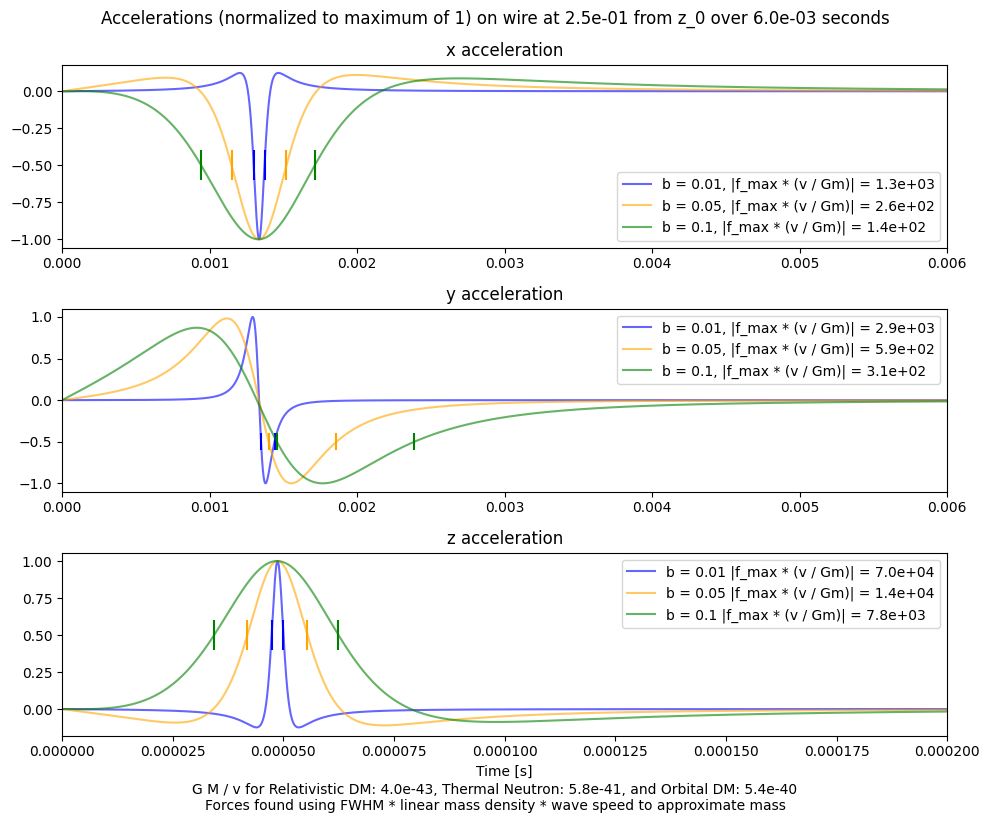

In [8]:
fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
ax3.set_xlabel('Time [s]')
colors = ['blue', 'orange', 'green']
z_t_max = 2e-4
for i in range(3):
    def fwhm(theory_abs):
        fMaxIdx = theory_abs.argmax()
        f_fwhm_left = np.where(theory_abs[t_eval < t_eval[fMaxIdx]] <= theory_abs[fMaxIdx] / 2)[0][-1]
        f_fwhm_right = np.where(theory_abs >= theory_abs[fMaxIdx] / 2)[0][-1]
        return [f_fwhm_left, f_fwhm_right]
    x_theory, y_theory, z_theory = theory_abs(t_eval, zwire[z_t], bs[i])
    print(f"b = {bs[i]}")
    # Plot FWHM`s and Get mass approximations
    x_fwhm_left, x_fwhm_right = fwhm(np.abs(x_theory))
    x_mass_approx = np.abs(t_eval[x_fwhm_left] - t_eval[x_fwhm_right]) * v_shear * mu
    ax1.vlines([t_eval[x_fwhm_left], t_eval[x_fwhm_right]], (x_theory[x_fwhm_left] / np.abs(x_theory).max()) -0.1, (x_theory[x_fwhm_left] / np.abs(x_theory).max()) + 0.1, colors=colors[i])
    print(f"    mass(x) ~= {x_mass_approx}")
    y_fwhm_left, y_fwhm_right = fwhm(np.abs(y_theory))
    y_mass_approx = 2 * np.abs(t_eval[y_fwhm_left] - t_eval[y_fwhm_right]) * v_shear * mu
    ax2.vlines([t_eval[y_fwhm_left], t_eval[y_fwhm_right]], (y_theory[y_fwhm_left] / np.abs(y_theory).max()) -0.1, (y_theory[y_fwhm_left] / np.abs(y_theory).max()) + 0.1, colors=colors[i])
    print(f"    mass(y) ~= {y_mass_approx}")
    z_fwhm_left, z_fwhm_right = fwhm(np.abs(z_theory))
    z_mass_approx = 2 * np.abs(t_eval[z_fwhm_left] - t_eval[z_fwhm_right]) * v_press * mu
    ax3.vlines([t_eval[z_fwhm_left], t_eval[z_fwhm_right]], (z_theory[z_fwhm_left] / np.abs(z_theory).max()) -0.1, (z_theory[z_fwhm_left] / np.abs(z_theory).max()) + 0.1, colors=colors[i])
    print(f"    mass(z) ~= {z_mass_approx}")
    # Plot accerlations
    ax1.plot(t_eval, x_theory / np.abs(x_theory).max(), label=f'b = {bs[i]}, |f_max * (v / Gm)| = {x_mass_approx * np.abs(x_theory).max():.1e}', alpha=0.6, color= colors[i])
    ax2.plot(t_eval, y_theory / np.abs(y_theory).max(), label=f'b = {bs[i]}, |f_max * (v / Gm)| = {y_mass_approx * np.abs(y_theory).max():.1e}', alpha=0.6, color= colors[i])
    ax3.plot(t_eval[t_eval < z_t_max], z_theory[t_eval < z_t_max] / np.abs(z_theory[t_eval < z_t_max]).max(), label=f'b = {bs[i]} |f_max * (v / Gm)| = {z_mass_approx * np.abs(z_theory).max():.1e}', alpha=0.6, color=colors[i])
    

# Graph aesthetics
ax1.set_xlim(t0, tf)
ax1.set_title('x acceleration')
# ax1.set_ylabel('x_acc / x_acc.max()')
ax1.legend(loc="lower right")

ax2.set_xlim(t0, tf)
ax2.set_title('y acceleration')
# ax2.set_ylabel('y_acc / y_acc.max()')
ax2.legend(loc="upper right")

ax3.set_xlim(t0, z_t_max)
ax3.set_title('z acceleration')
# ax3.set_ylabel('z_acc / z_acc.max()')
ax3.legend(loc="upper right")

fig1.suptitle(f'Accelerations (normalized to maximum of 1) on wire at {zwire[z_t]:.1e} from z_0 over {tf:.1e} seconds')
fig1.text(0.5,-.02, s = f"G M / v for Relativistic DM: {small[0]:.1e}, Thermal Neutron: {small[1]:.1e}, and Orbital DM: {small[2]:.1e}\nForces found using FWHM * linear mass density * wave speed to approximate mass", ha='center')
fig1.set_figwidth(10)
fig1.set_figheight(8)
fig1.tight_layout()